Description : Using an LSTM model to predict the closing stock price of a corporation on a given day using the last 60 day stock price.

In [63]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

from pandas_datareader import data as pdr
import yfinance as yf

In [84]:
# Get the stock quote from Yahoo Finance

stock_code = "AMZN"
ticker = yf.Ticker(stock_code)

df = ticker.history(period="10y", auto_adjust=True)


# Show data
df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-06-25,11.0150,11.0795,10.9000,11.0035,47646000,0,0.0
2012-06-26,11.0725,11.3195,11.0725,11.2805,75082000,0,0.0
2012-06-27,11.2505,11.3750,11.1650,11.2810,55984000,0,0.0
2012-06-28,11.1960,11.2310,10.9375,11.0655,59896000,0,0.0
2012-06-29,11.2350,11.4175,11.1855,11.4175,72288000,0,0.0
2012-07-02,11.4650,11.4670,11.3170,11.4660,46614000,0,0.0
2012-07-03,11.4570,11.4765,11.3795,11.4765,26634000,0,0.0
2012-07-05,11.4310,11.5250,11.3265,11.3530,53646000,0,0.0
2012-07-06,11.3175,11.4450,11.2090,11.2525,64064000,0,0.0


There are several missing dates. Those are the dates where data is not available. This is due to trading being closed on weekends and public holidays.

In [66]:
# Get rows and columns
df.shape

(2517, 7)

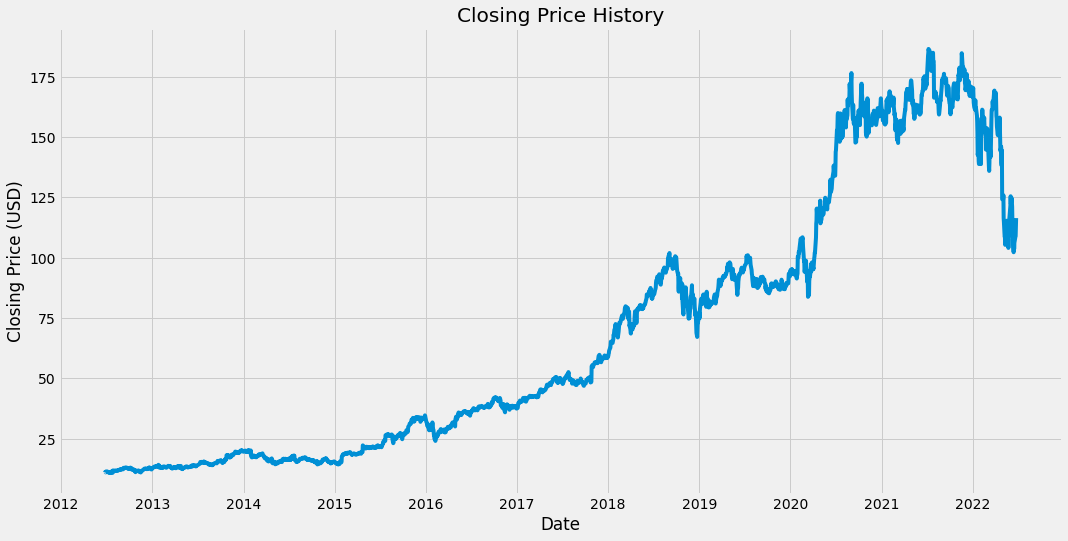

In [67]:
 # Visualise the closing price history
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.plot(df["Close"])
plt.show()

In [68]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.0,2517.000000
mean,68.605345,69.354637,67.763677,68.571468,8.007435e+07,0.0,0.007946
std,54.057783,54.693522,53.338648,54.002110,4.238327e+07,0.0,0.398647
min,10.781500,10.865000,10.630500,10.768000,1.762600e+07,0.0,0.000000
25%,18.729000,18.928499,18.577499,18.720501,5.353200e+07,0.0,0.000000
50%,48.416000,48.724499,47.986000,48.303501,6.864400e+07,0.0,0.000000
75%,96.648499,97.550003,95.378998,96.384003,9.293600e+07,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,4.771220e+08,0.0,20.000000


In [69]:
# Create a new dataframe with only close column
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get number of rows to train LSTM model
training_data_len = math.ceil(len(dataset) * 0.8)  # Assuming 80% training and 20% test data

training_data_len

2014

In [70]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00133957],
       [0.00291521],
       [0.00291805],
       ...,
       [0.55847897],
       [0.57833083],
       [0.60119738]])

In [71]:
# Create the training dataset
train_data = scaled_data[0:training_data_len, :]

# Split into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [72]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

LSTM expects the data to be shaped in 3 dimensions - Number of samples x Timestamps x Number of features

Currently, the data is in 2 dimensions (num of samples x timestamps)

In [73]:
# Get shape of x_train
n_rows, n_cols = x_train.shape

x_train = np.reshape(x_train, (n_rows, n_cols, 1)) # 1 since output is just the closing price i.e., num of features is 1

In [74]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_cols, 1)))
model.add(LSTM(50, return_sequences=False)) # Setting it false this time since we are not using any additional LSTM layers in the model
model.add(Dense(25))
model.add(Dense(1))

In [75]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [76]:
model.fit(x_train, y_train, batch_size=16, epochs=5)

Epoch 1/5
123/123 [==============================] - 4s 10ms/step - loss: 0.0023
Epoch 2/5
123/123 [==============================] - 2s 14ms/step - loss: 2.5986e-04
Epoch 3/5
123/123 [==============================] - 2s 13ms/step - loss: 2.2920e-04
Epoch 4/5
123/123 [==============================] - 2s 13ms/step - loss: 2.2996e-04
Epoch 5/5
123/123 [==============================] - 2s 13ms/step - loss: 1.8991e-04


In [77]:
# Create the test dataset
# The test dataset will need the last 60 values of the training data as the y_test[0] is the output of the last 60 values of x_train
test_data = scaled_data[training_data_len - 60:, :]

# Create the dataset x_test, y_test
x_test = []
y_test = dataset[training_data_len:, :] # These values are not scaled

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [78]:
# Convert the data to numpy array
x_test = np.array(x_test)

In [79]:
# Reshape the data to convert x_test to 3d for LSTM consumption

# Get shape of x_test
n_rows, n_cols = x_test.shape

x_test = np.reshape(x_test, (n_rows, n_cols, 1)) # 1 since output is just the closing price i.e., num of features is 1

In [80]:
# Get models predicted price values
y_pred = model.predict(x_test)

# Predictions need to be unscaled to match with actual prediction values
y_pred = scaler.inverse_transform(y_pred)

In [81]:
# Get RMSE for the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


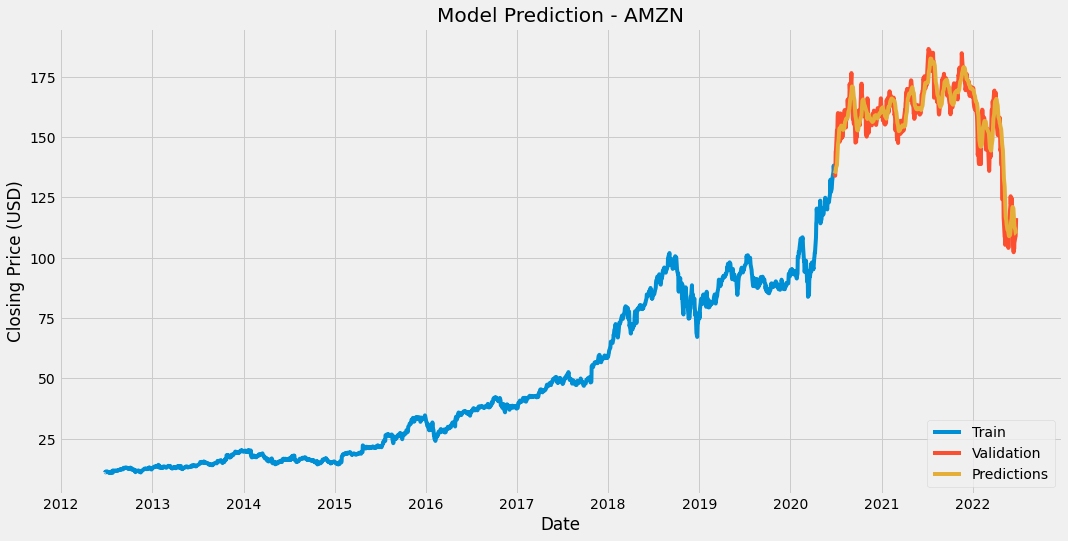

In [82]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = y_pred

# Visualise the data
plt.figure(figsize=(16,8))
title = "Model Prediction - " + stock_code
plt.title(title)
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc="lower right")
plt.show()

In [83]:
# Show the valid and predicted price
valid

,Close,Predictions
Date,,
2020-06-26,134.643494,134.963974
2020-06-29,134.018997,135.569626
2020-06-30,137.940994,135.876846
2020-07-01,143.934998,136.306198
2020-07-02,144.514999,137.246933
...,...,...
2022-06-17,106.220001,113.027916
2022-06-21,108.680000,111.494934
2022-06-22,108.949997,110.466888
